## main

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':30,
    'ytick.labelsize':30,
    'axes.labelsize':40,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
src_n = 1;
# output directory
dir = f'../data.lbm/{src_n}/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Winter meeting figures

In [4]:
# id += 1
id = -5
initFluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[1]}.csv").set_index(["id_x","id_y"]).sort_index()
finalFluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()

In [5]:
particleDf = pd.read_csv(dir+"particlesTrj.csv")
radius = 4

initialPosX = particleDf.position_x.values[1]
initialPosY = particleDf.position_y.values[1]
finalPosX = particleDf.position_x.values[id]
finalPosY = particleDf.position_y.values[id]

In [6]:
auxRadius = radius+0.5
uM = np.sqrt(finalFluidDf.query(f'(coordinate_x - {finalPosX})**2 + (coordinate_y - {finalPosY})**2 > {auxRadius}**2').fluidVelocity_x**2 + finalFluidDf.query(f'(coordinate_x - {finalPosX})**2 + (coordinate_y - {finalPosY})**2 > {auxRadius}**2').fluidVelocity_y**2).max()
uM

np.float64(0.0007957299634271393)

In [7]:
def winterMeetingFigAlt(df):
    # figure preparation
    fig, axes = plt.subplots(figsize = (8,8))
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar
    
    # Create a meshgrid for plotting
    x_unique = df['coordinate_x'].unique()
    y_unique = df['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)
    
    xmax = x_unique.max()
    xmin = x_unique.min()
    ymax = y_unique.max()
    ymin = y_unique.min()
    
    # first plot
    upperLim = 1
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes.streamplot(X, Y, 
        df.fluidVelocity_x.unstack().values.transpose(),
        df.fluidVelocity_y.unstack().values.transpose(),
#         density=1.0, linewidth=1, color="black",
        density=1.5, linewidth=1, color="black",
    )
    
    
    axes.pcolormesh(X, Y,
        (np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2)/uM).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
    axes.set_xticks([xmin, 0, xmax])
    axes.set_xlabel("$x ~ (\\mathrm{\\mu m})$")
    axes.set_yticks([ymin, 0, ymax])
    axes.set_ylabel("$y ~ (\\mathrm{\\mu m})$")
    cbar_ax = fig.add_axes([0.9, 0.15, 0.04, 0.7])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$\\mathbf{u}/u_\\mathrm{max}$')

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in custom_ticks])

    # Create a mask as a filled polygon (circle patch with alpha for masking)
    myColor='#F7F7F7'
    mask = Circle((finalPosX, finalPosY), radius, transform=axes.transData, color=myColor, linestyle='', alpha=1, zorder=2)
    axes.add_patch(mask)

    axes.plot(particleDf.position_x.values[:id], particleDf.position_y.values[:id], color='#CA3D34', linewidth=2, zorder=4)  # Trajectory line


    return fig, axes

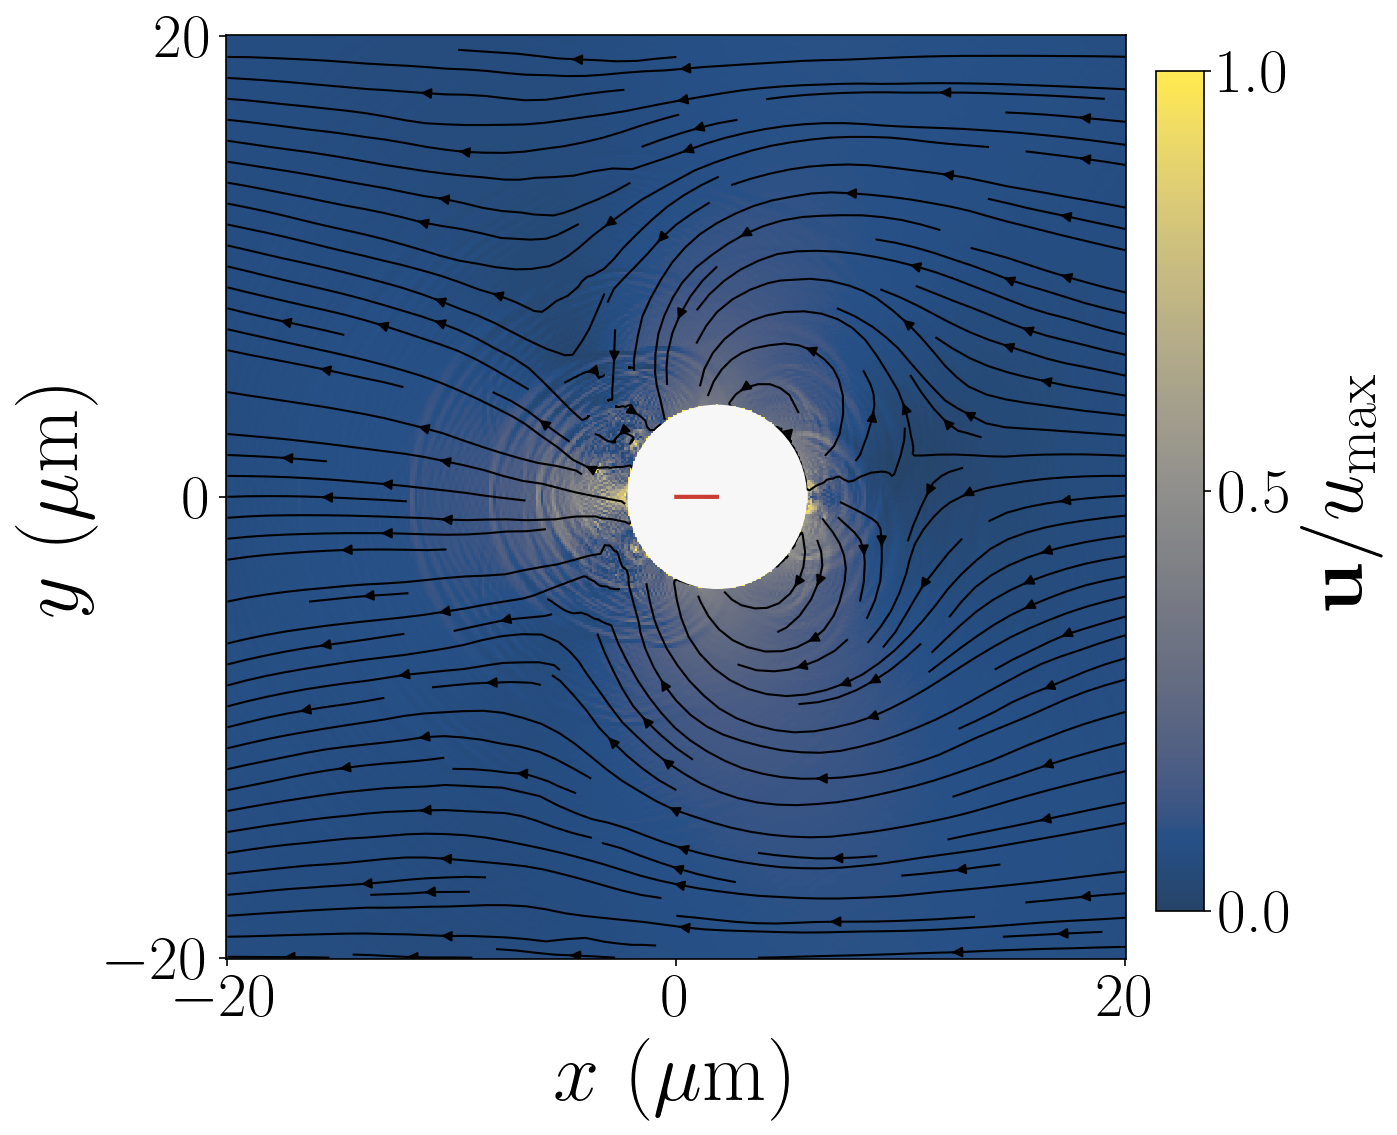

In [8]:
# fig, axes = winterMeetingFigAlt(finalFluidDf.query('coordinate_x**2 <= 25 & coordinate_y**2 <= 25'))
fig, axes = winterMeetingFigAlt(finalFluidDf)
plt.savefig(f"figs/{src_n}/figure1.png", format="png", transparent=True, dpi=72, bbox_inches="tight")
plt.savefig(f"figs/{src_n}/figure1hd.png", format="png", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

# Stability analysis

In an effort to verify a stable equilibrium state was achieved, the mean fluid speed is studied as a function of time.

In [9]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [10]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

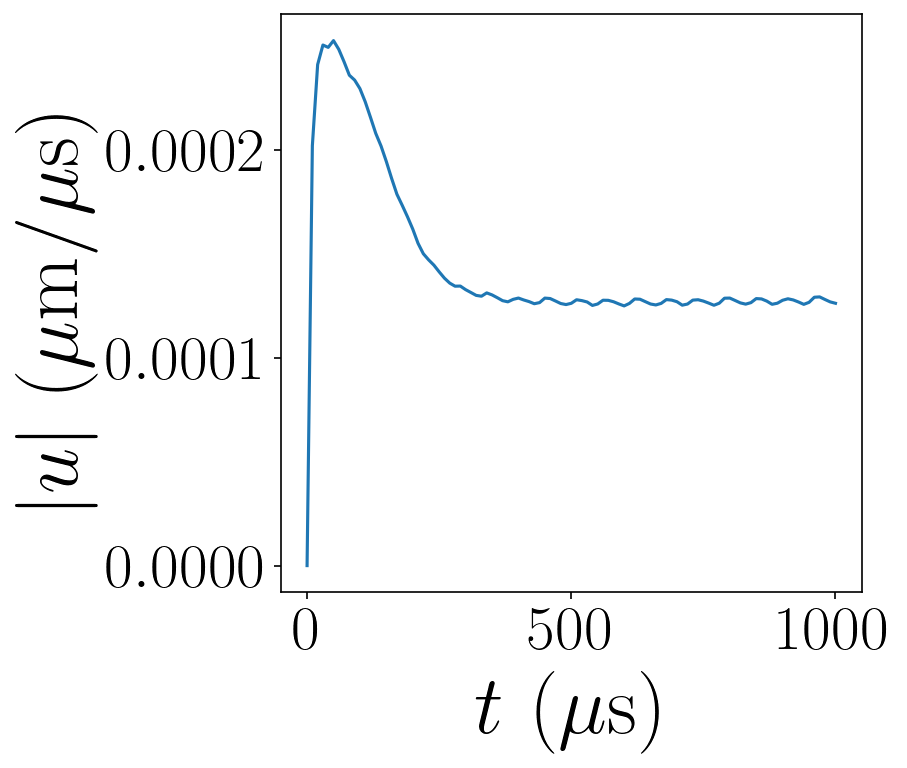

In [11]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()